# Going Deeper(CV)
# 15. 도로 영역을 찾자! - 세그멘테이션 모델 만들기 [프로젝트]

## 15-1. 프로젝트 : 개선된 U-Net 모델 만들기

### 주요 라이브러리 버전 체크

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


In [2]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

### Step 1. KITTI 데이터셋 수집과 구축

In [3]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

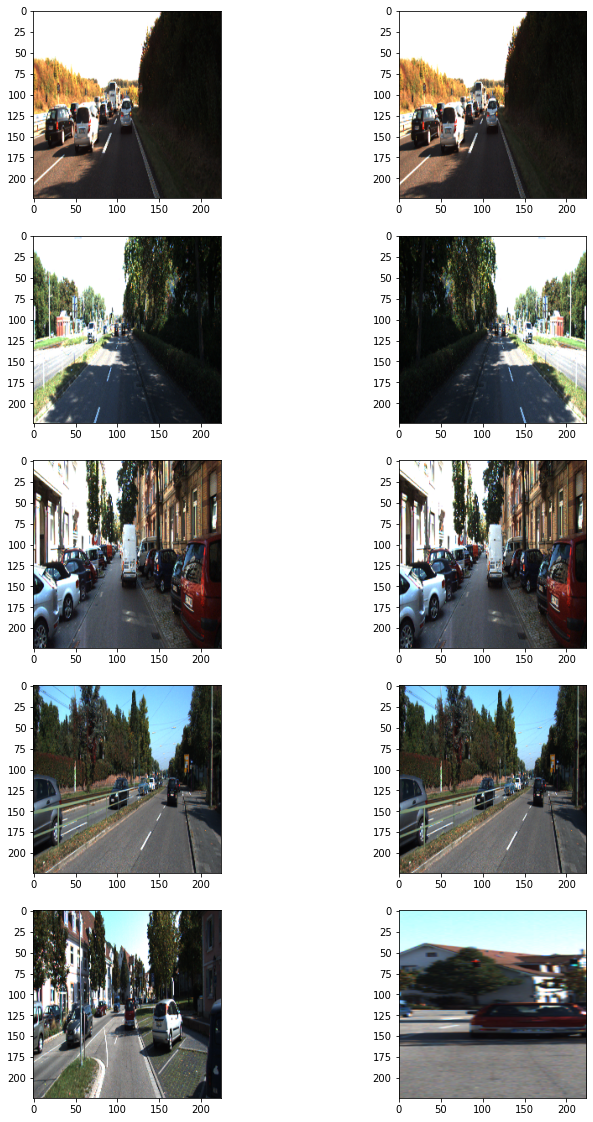

In [5]:
# dir_path = 'data/semantic_segmentation/data/training'
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [11]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [12]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현

#### U-Net

[참고 링크1](https://joungheekim.github.io/2020/09/28/paper-review/)

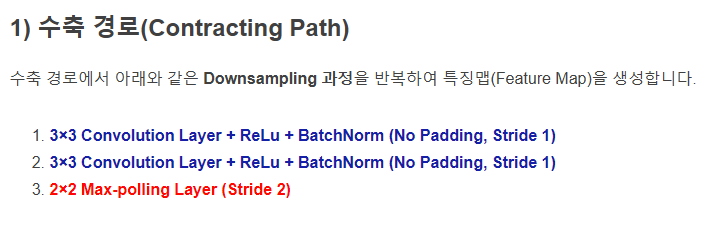

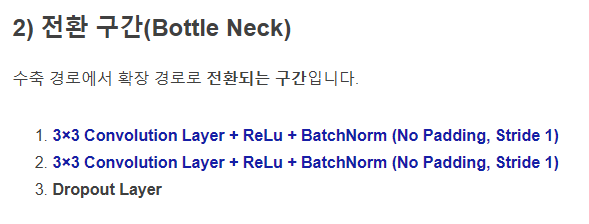

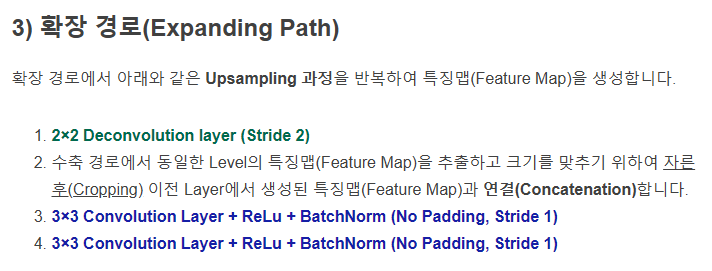

위 논문리뷰 글에서 참고한 U-Net 모델의 구조입니다.  


구조를 확인해보니 **수축 경로와 전환 구간에서 사용할 블럭**과 **확장 경로에서 사용할 블럭**을 함수로 따로 선언하면 될 것 같습니다.

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 수축 경로와 전환 구간에서 사용할 block
def contracting_block(channels, inputs, dropout=False, maxpool=True):
    conv = Conv2D(channels, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    conv =  Conv2D(channels, 3, padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    if dropout: # 전환 구간에서 dropout을 사용하기 위함
        conv = Dropout(0.5)(conv)
    if maxpool: # 전환 구간에서 maxpooling을 사용하지 않기 위함
        pool = MaxPooling2D((2, 2))(conv)
        return conv, pool
    return conv

# 확장 경로에서 사용할 블럭
def Expanding_block(channels, inputs, conv):
    up = Conv2DTranspose(channels, 2, strides=(2, 2), padding="same")(inputs)
    merge = Concatenate(axis=-1)([conv, up])
    up = Conv2D(channels, 3, padding="same", kernel_initializer='he_normal')(merge)
    up = BatchNormalization()(up)
    up = Activation("relu")(up)
    up = Conv2D(channels, 3, padding="same", kernel_initializer='he_normal')(up)
    up = BatchNormalization()(up)
    up = Activation("relu")(up)
    return up

def unet_build(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    conv1, pool1 = contracting_block(64, inputs)

    conv2, pool2 = contracting_block(128, pool1)

    conv3, pool3 = contracting_block(256, pool2)

    conv4, pool4 = contracting_block(512, pool3, dropout=True)

    conv5 = contracting_block(1024, pool4, dropout=True, maxpool=False)

    up4 = Expanding_block(512, conv5, conv4)

    up3 = Expanding_block(256, up4, conv3)

    up2 = Expanding_block(128, up3, conv2)

    up1 = Expanding_block(64, up2, conv1)

    outputs = Conv2D(2, 3, activation='relu', padding='same')(up1)
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(outputs)

    model = Model(inputs, outputs)
    return model

In [61]:
unet_model = unet_build()
unet_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_384 (Conv2D)             (None, 224, 224, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_340 (BatchN (None, 224, 224, 64) 256         conv2d_384[0][0]                 
__________________________________________________________________________________________________
activation_340 (Activation)     (None, 224, 224, 64) 0           batch_normalization_340[0][0]    
___________________________________________________________________________________________

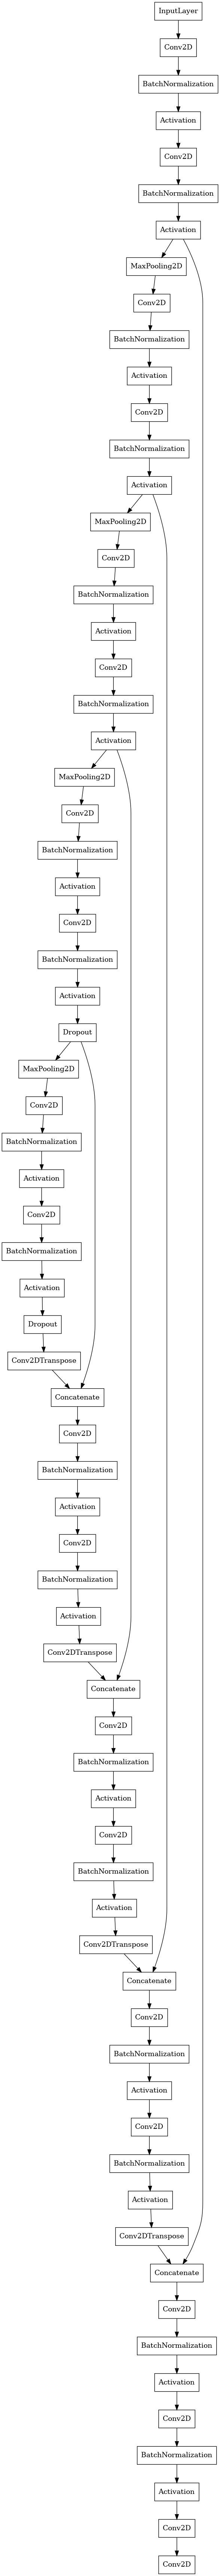

In [62]:
from tensorflow.keras.utils import plot_model

# 모델 그래프를 그리기 위해 plot_model 함수를 사용합니다.
plot_model(unet_model, to_file='unet_model.png', show_shapes=False, show_layer_names=False)

#### U-Net++

[참고 링크2](https://wsshin.tistory.com/2)

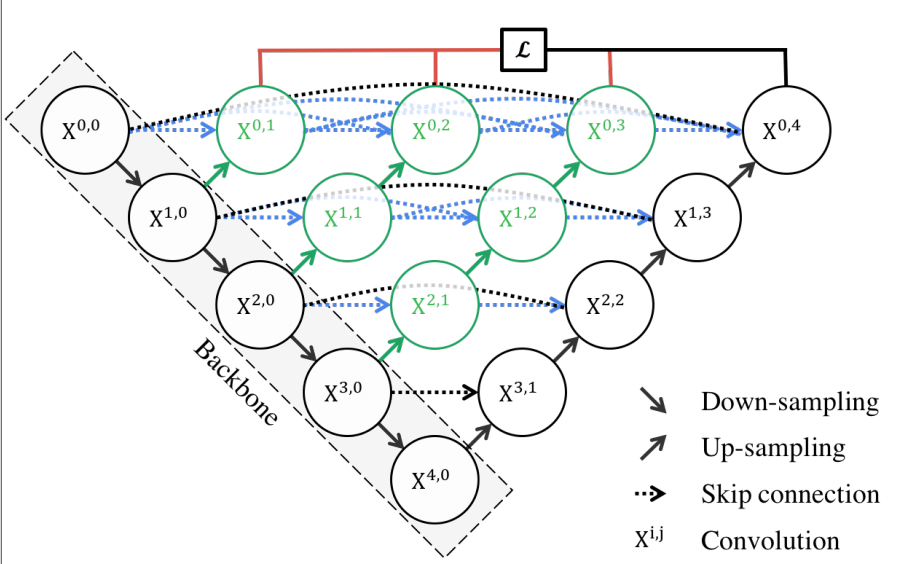

검은 원과 선이 기존 U-Net의 구조이며 초록 원과 파란 선이 U-Net++의 추가적인 아이디어를 의미합니다.

U-Net과 U-Net++의 차이점
1. **Re-designed skip pathways**: U-Net++에선 DenseNet의 아이디어를 차용해 인코더와 디코더 사이의 Semantic Gap을 연결시켜 줍니다.
2. **Deep Supervision**: 각 브랜치의 출력(빨간 선)을 평균해서 최종 결과로 사용하는 방법입니다.

저 모든 점선들이 skip connection, 우상향 실선들이 up-sampling을 의미합니다.  

[참고 링크3](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py)

그리고 위 깃헙을 보면 모든 원이 컨볼루션을 포함한 하나의 블럭인 것 같습니다.(초록색 원 포함)

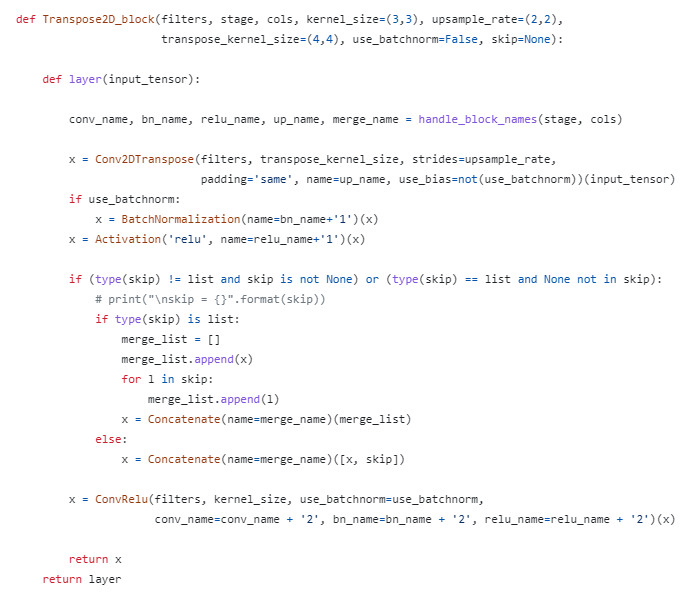

skip connection을 concatenate를 이용해 구현한 후에 ConvRelu(conv+relu+batchnorm 2회가 저장된 함수)를 실행하는 것을 확인할 수 있습니다.  

즉, 하나의 **초록 원**은 **같은 층의 이전 원**을 **skip connection**한 결과와 **한 층 아래의 원**을 **upsampling**(저는 Conv2DTranspose를 사용했습니다.)한 결과를 **합친(concatenate)** 결과를 **2회 컨볼루션한 결과**임을 알 수 있습니다.

[참고 링크4](https://eda-ai-lab.tistory.com/547)

위 블로그에서 Deep Supervision에 대한 설명을 많이 참고했습니다.  

Deep Supervision은 앞서 설명한 바와 같이 x01, x02, x03, x04의 출력 결과의 평균을 최종 output으로 설정합니다.  
여기서 x01, x02, x03, x04를 각각 1*1커널 컨볼루션 + sigmoid하여 [x01, x02, x03, x04]의 형태로 output으로 내보냅니다.

[참고 링크5](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)

여기서 dice_coef와 binary_cross_entropy를 결합한 연산 코드를 참고하였습니다.  
쉽게 요약하면 pred와 실제 label 사이의 차이를 dice_coef 방식으로 구해 dice_loss를 산출한 후 이를 binary_cross_entropy에서 차감한 것에 0.5를 곱하여 loss function으로 사용하고 있습니다...만 왜 이렇게 하는지 이유는 잘 모르겠습니다..

In [63]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def contracting_block(channels, inputs, dropout=False, maxpool=True):
    conv = Conv2D(channels, 3, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(channels, 3, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    if dropout:
        conv = Dropout(0.5)(conv)
    if maxpool:
        pool = MaxPooling2D((2, 2))(conv)
        return conv, pool
    return conv

def Expanding_block(channels, inputs, conv_list): # conv 레이어의 결과를 리스트 형태로 받도록 바꿨습니다.
    up = Conv2DTranspose(channels, 2, strides=(2, 2), padding="same")(inputs)
    conv_list.append(up)
    merge = Concatenate(axis=-1)(conv_list)
    up = Conv2D(channels, 3, padding="same")(merge)
    up = BatchNormalization()(up)
    up = Activation("relu")(up)
    up = Conv2D(channels, 3, padding="same")(up)
    up = BatchNormalization()(up)
    up = Activation("relu")(up)
    return up

def unet_pp_build(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)

    x0_0, pool1 = contracting_block(64, inputs)

    x1_0, pool2 = contracting_block(128, pool1)

    x2_0, pool3 = contracting_block(256, pool2)

    x3_0, pool4 = contracting_block(512, pool3, dropout=True)

    x4_0 = contracting_block(1024, pool4, dropout=True, maxpool=False)

    x3_1 = Expanding_block(512, x4_0, [x3_0])

    x2_1 = Expanding_block(256, x3_0, [x2_0])
    x2_2 = Expanding_block(256, x3_1, [x2_0, x2_1])

    x1_1 = Expanding_block(128, x2_0, [x1_0])
    x1_2 = Expanding_block(128, x2_1, [x1_0, x1_1])
    x1_3 = Expanding_block(128, x2_2, [x1_0, x1_1, x1_2])

    x0_1 = Expanding_block(64, x1_0, [x0_0])
    x0_2 = Expanding_block(64, x1_1, [x0_0, x0_1])
    x0_3 = Expanding_block(64, x1_2, [x0_0, x0_1, x0_2])
    x0_4 = Expanding_block(64, x1_3, [x0_0, x0_1, x0_2, x0_3])
    
    if deep_supervision == True:
        x0_1 = Conv2D(1, 1, activation="sigmoid")(x0_1)
        x0_2 = Conv2D(1, 1, activation="sigmoid")(x0_2)
        x0_3 = Conv2D(1, 1, activation="sigmoid")(x0_3)
        x0_4 = Conv2D(1, 1, activation="sigmoid")(x0_4)

        model = Model(inputs, [x0_1, x0_2, x0_3, x0_4])
    else:
        outputs = Conv2D(2, 3, activation='relu', padding='same')(x0_4)
        outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(outputs)
    
        model = Model(inputs, outputs)
        
    return model

In [64]:
from tensorflow.keras import backend as K
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [65]:
unet_pp_model = unet_pp_build()
unet_pp_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_404 (Conv2D)             (None, 224, 224, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_358 (BatchN (None, 224, 224, 64) 256         conv2d_404[0][0]                 
__________________________________________________________________________________________________
activation_358 (Activation)     (None, 224, 224, 64) 0           batch_normalization_358[0][0]    
___________________________________________________________________________________________

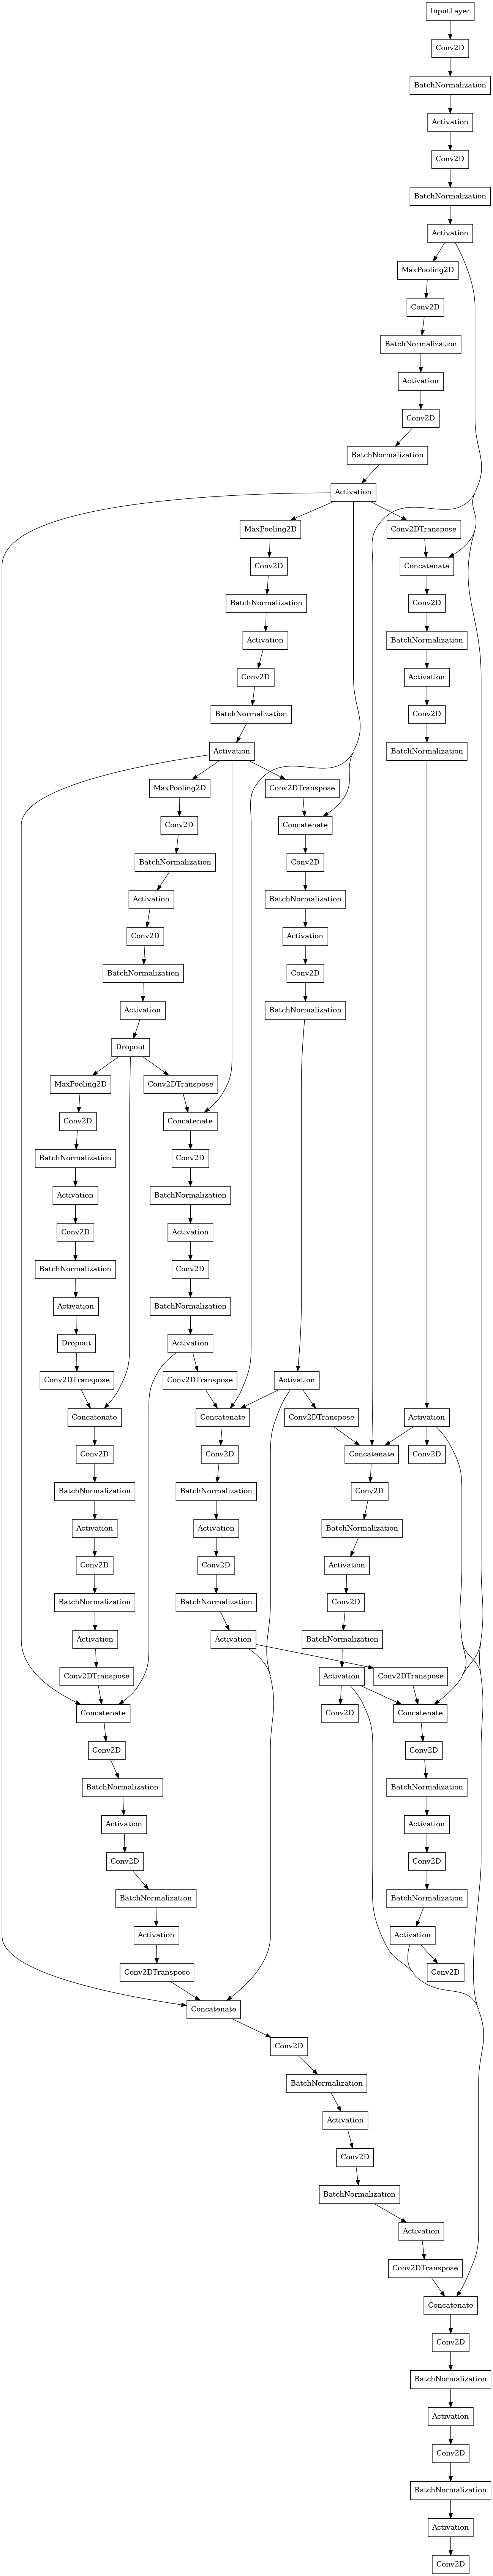

In [66]:
from tensorflow.keras.utils import plot_model

# 모델 그래프를 그리기 위해 plot_model 함수를 사용합니다.
plot_model(unet_pp_model, to_file='model.png', show_shapes=False, show_layer_names=False)

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

### 모델 학습

In [94]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet1.h5'

unet_model = unet_build()
unet_model.compile(optimizer = Adam(0.05), loss = 'binary_crossentropy')

unet_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 10s 718ms/step - loss: 0.3210 - val_loss: 0.2819
Epoch 2/100
11/11 [==============================] - 8s 686ms/step - loss: 0.2499 - val_loss: 0.2819
Epoch 3/100
11/11 [==============================] - 8s 690ms/step - loss: 0.2868 - val_loss: 0.2819
Epoch 4/100
11/11 [==============================] - 8s 688ms/step - loss: 0.1295 - val_loss: 0.2819
Epoch 5/100
11/11 [==============================] - 8s 683ms/step - loss: 0.0353 - val_loss: 0.2819
Epoch 6/100
11/11 [==============================] - 7s 678ms/step - loss: 0.0416 - val_loss: 0.2819
Epoch 7/100
11/11 [==============================] - 7s 675ms/step - loss: 0.0312 - val_loss: 0.2834
Epoch 8/100
11/11 [==============================] - 7s 671ms/step - loss: 0.0288 - val_loss: 0.2818
Epoch 9/100
11/11 [==============================] - 7s 668ms/step - loss: 0.0293 - val_loss: 0.2790
Epoch 10/100
11/11 [==============================] - 7s 669ms/step - loss: 0.0278 - val_l

In [ ]:
# 배치 사이즈를 8로 변경합니다.(16으로 놔두면 GPU 메모리 부족으로 훈련이 진행되지 않습니다.)
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    batch_size=8,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False,
    batch_size=8,
)

In [93]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp5.h5'

unet_pp_model = unet_pp_build()
unet_pp_model.compile(optimizer = Adam(0.05), loss=bce_dice_loss)

unet_pp_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_pp_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 28s 1s/step - loss: -0.7402 - conv2d_536_loss: -0.1531 - conv2d_537_loss: -0.1507 - conv2d_538_loss: -0.1919 - conv2d_539_loss: -0.2444 - val_loss: 1.0859 - val_conv2d_536_loss: 0.3014 - val_conv2d_537_loss: 0.2615 - val_conv2d_538_loss: 0.2615 - val_conv2d_539_loss: 0.2615
Epoch 2/100
22/22 [==============================] - 22s 1s/step - loss: -1.5672 - conv2d_536_loss: -0.3480 - conv2d_537_loss: -0.3553 - conv2d_538_loss: -0.4070 - conv2d_539_loss: -0.4569 - val_loss: 1.0846 - val_conv2d_536_loss: 0.2646 - val_conv2d_537_loss: 0.2969 - val_conv2d_538_loss: 0.2615 - val_conv2d_539_loss: 0.2615
Epoch 3/100
22/22 [==============================] - 22s 988ms/step - loss: -1.4700 - conv2d_536_loss: -0.3280 - conv2d_537_loss: -0.3254 - conv2d_538_loss: -0.3397 - conv2d_539_loss: -0.4769 - val_loss: 1.0460 - val_conv2d_536_loss: 0.2615 - val_conv2d_537_loss: 0.2615 - val_conv2d_538_loss: 0.2615 - val_conv2d_539_loss: 0.2615
Epoch 4/100
2

### 결과 시각화

In [95]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet1.h5'
unet_model = tf.keras.models.load_model(model_path)

In [96]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp5.h5'
unet_pp_model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss})

In [68]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = (intersection / union).astype(np.float32)
#     print('IoU : %f' % iou_score )
    return iou_score

In [48]:
def get_output(model, preproc, image_path, output_path, label_path, show=False):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    try:
        output1, output2, output3, output4 = model(np.expand_dims(processed["image"]/255,axis=0))
        output = (output1 + output2 + output3 + output4) / 4
    except:
        output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    if show == True:
        output.show()   # 도로로 판단한 영역을 시각화!

    if label_path:
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

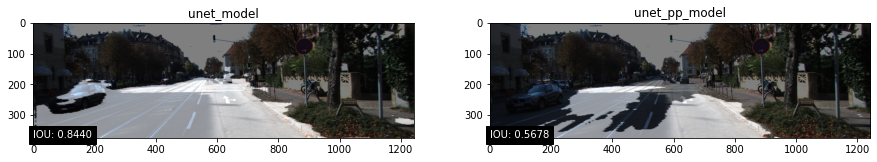

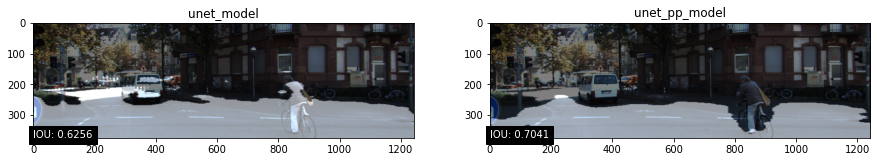

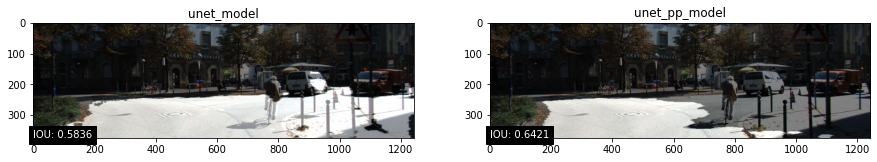

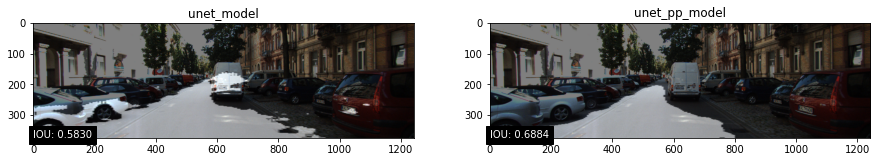

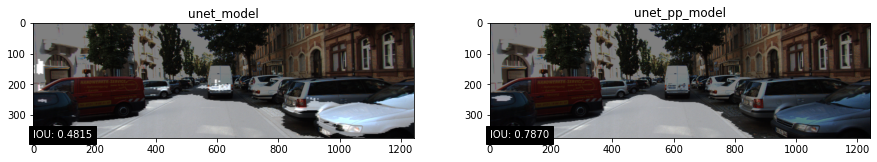

In [97]:
import matplotlib.pyplot as plt

num_images = 5  # 시각화할 이미지 수

for i in range(1, num_images + 1):
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'

    # unet_model 예측 결과 얻기
    unet_output, unet_prediction, unet_target = get_output(
        unet_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # unet_pp_model 예측 결과 얻기
    unet_pp_output, unet_pp_prediction, unet_pp_target = get_output(
        unet_pp_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_pp_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # IOU 스코어 계산
    unet_iou = calculate_iou_score(unet_target, unet_prediction)
    unet_pp_iou = calculate_iou_score(unet_pp_target, unet_pp_prediction)

    # 이미지 결과 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # unet_model 결과
    axes[0].imshow(unet_output)
    axes[0].set_title("unet_model")
    axes[0].text(0, unet_output.height, f"IOU: {unet_iou:.4f}", color='white', backgroundcolor='black')

    # unet_pp_model 결과
    axes[1].imshow(unet_pp_output)
    axes[1].set_title("unet_pp_model")
    axes[1].text(0, unet_pp_output.height, f"IOU: {unet_pp_iou:.4f}", color='white', backgroundcolor='black')


    plt.show()


U-Net++가 평균적으로 성능이 더 좋네요!

추가적으로 lr과 epoch를 바꿔서 실험했던 결과들을 아래에 첨부합니다.

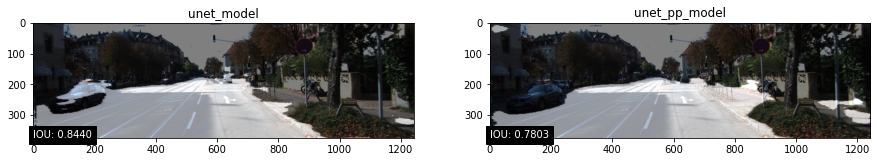

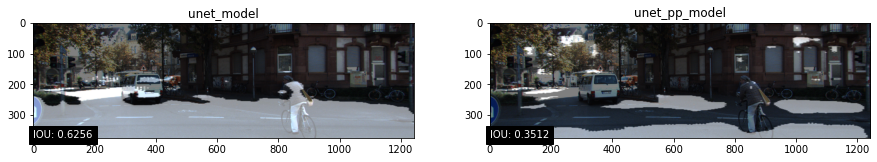

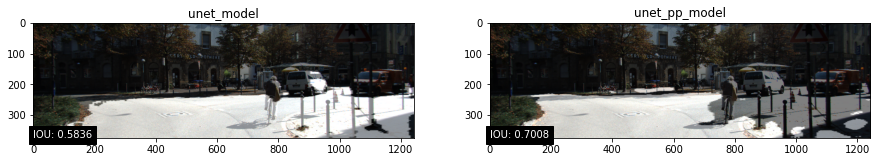

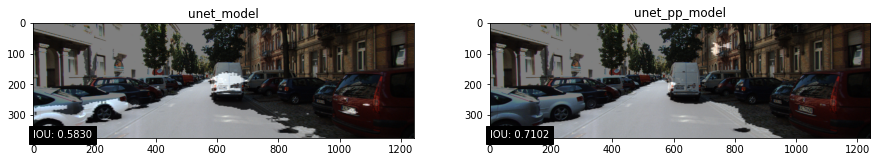

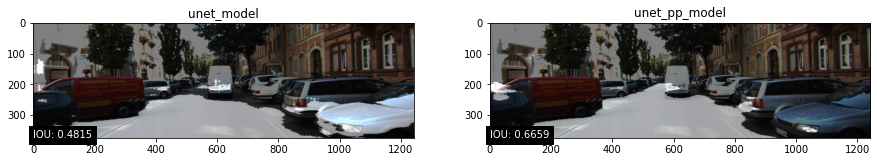

In [98]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'
unet_pp_model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss})

import matplotlib.pyplot as plt

num_images = 5  # 시각화할 이미지 수

for i in range(1, num_images + 1):
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'

    # unet_model 예측 결과 얻기
    unet_output, unet_prediction, unet_target = get_output(
        unet_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # unet_pp_model 예측 결과 얻기
    unet_pp_output, unet_pp_prediction, unet_pp_target = get_output(
        unet_pp_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_pp_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # IOU 스코어 계산
    unet_iou = calculate_iou_score(unet_target, unet_prediction)
    unet_pp_iou = calculate_iou_score(unet_pp_target, unet_pp_prediction)

    # 이미지 결과 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # unet_model 결과
    axes[0].imshow(unet_output)
    axes[0].set_title("unet_model")
    axes[0].text(0, unet_output.height, f"IOU: {unet_iou:.4f}", color='white', backgroundcolor='black')

    # unet_pp_model 결과
    axes[1].imshow(unet_pp_output)
    axes[1].set_title("unet_pp_model")
    axes[1].text(0, unet_pp_output.height, f"IOU: {unet_pp_iou:.4f}", color='white', backgroundcolor='black')


    plt.show()


lr=? epoch=?

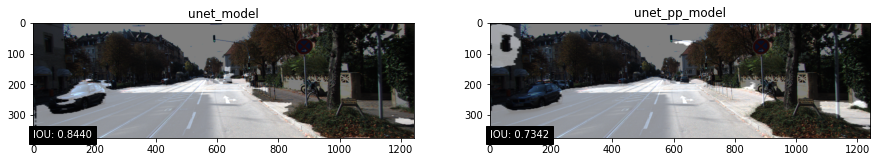

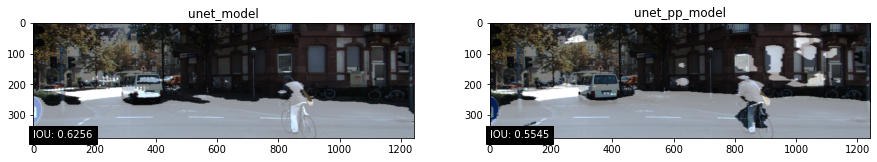

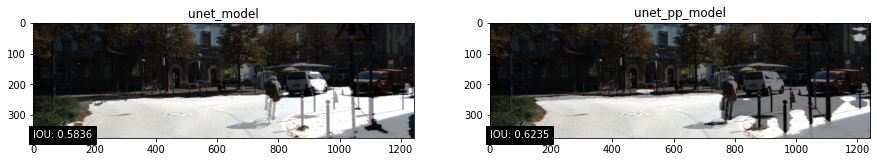

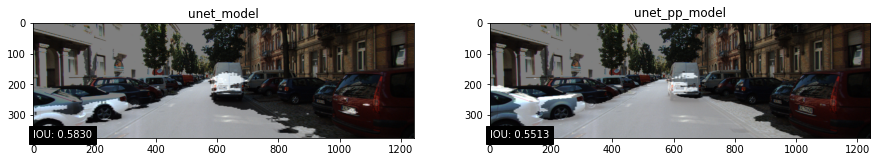

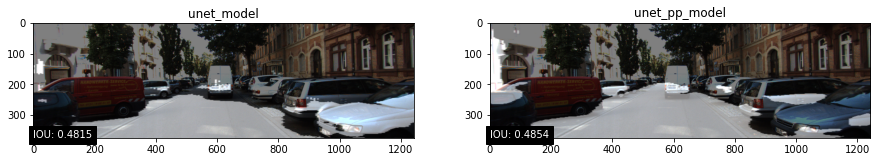

In [100]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp2.h5'
unet_pp_model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss})

import matplotlib.pyplot as plt

num_images = 5  # 시각화할 이미지 수

for i in range(1, num_images + 1):
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'

    # unet_model 예측 결과 얻기
    unet_output, unet_prediction, unet_target = get_output(
        unet_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # unet_pp_model 예측 결과 얻기
    unet_pp_output, unet_pp_prediction, unet_pp_target = get_output(
        unet_pp_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_pp_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # IOU 스코어 계산
    unet_iou = calculate_iou_score(unet_target, unet_prediction)
    unet_pp_iou = calculate_iou_score(unet_pp_target, unet_pp_prediction)

    # 이미지 결과 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # unet_model 결과
    axes[0].imshow(unet_output)
    axes[0].set_title("unet_model")
    axes[0].text(0, unet_output.height, f"IOU: {unet_iou:.4f}", color='white', backgroundcolor='black')

    # unet_pp_model 결과
    axes[1].imshow(unet_pp_output)
    axes[1].set_title("unet_pp_model")
    axes[1].text(0, unet_pp_output.height, f"IOU: {unet_pp_iou:.4f}", color='white', backgroundcolor='black')


    plt.show()


lr=? epoch=100

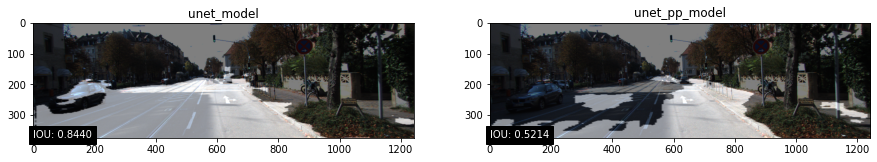

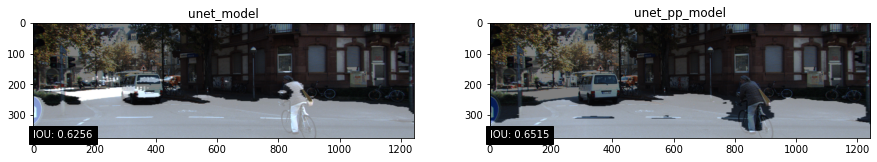

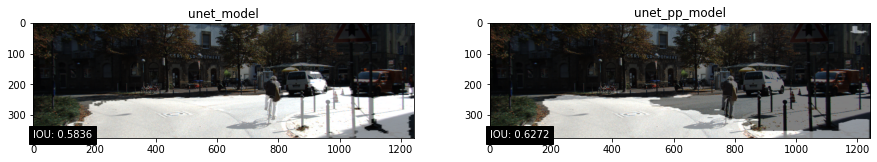

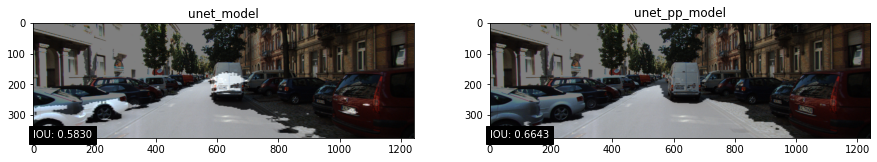

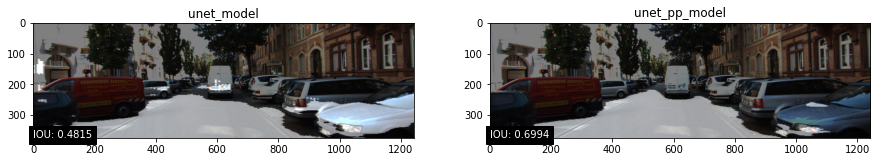

In [101]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp3.h5'
unet_pp_model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss})

import matplotlib.pyplot as plt

num_images = 5  # 시각화할 이미지 수

for i in range(1, num_images + 1):
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'

    # unet_model 예측 결과 얻기
    unet_output, unet_prediction, unet_target = get_output(
        unet_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # unet_pp_model 예측 결과 얻기
    unet_pp_output, unet_pp_prediction, unet_pp_target = get_output(
        unet_pp_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_pp_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # IOU 스코어 계산
    unet_iou = calculate_iou_score(unet_target, unet_prediction)
    unet_pp_iou = calculate_iou_score(unet_pp_target, unet_pp_prediction)

    # 이미지 결과 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # unet_model 결과
    axes[0].imshow(unet_output)
    axes[0].set_title("unet_model")
    axes[0].text(0, unet_output.height, f"IOU: {unet_iou:.4f}", color='white', backgroundcolor='black')

    # unet_pp_model 결과
    axes[1].imshow(unet_pp_output)
    axes[1].set_title("unet_pp_model")
    axes[1].text(0, unet_pp_output.height, f"IOU: {unet_pp_iou:.4f}", color='white', backgroundcolor='black')


    plt.show()


lr=? epoch=50

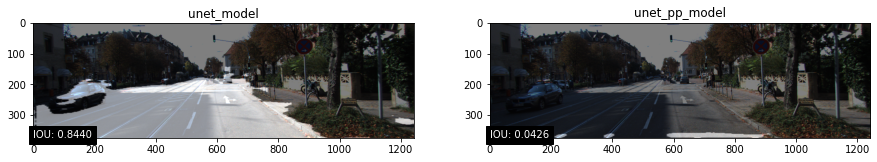

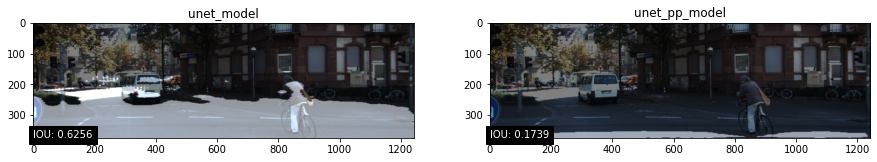

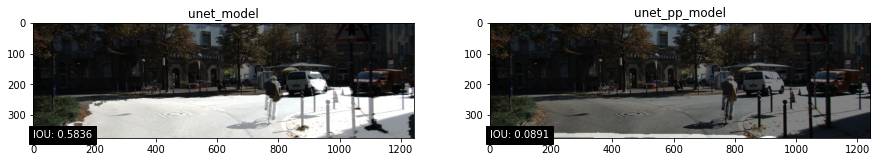

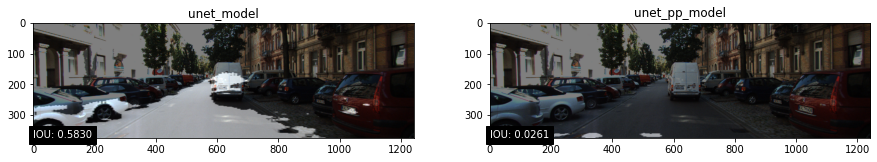

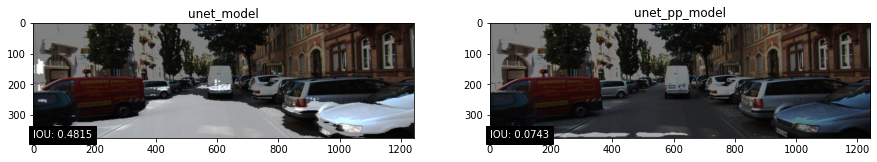

In [102]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp4.h5'
unet_pp_model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss})

import matplotlib.pyplot as plt

num_images = 5  # 시각화할 이미지 수

for i in range(1, num_images + 1):
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'

    # unet_model 예측 결과 얻기
    unet_output, unet_prediction, unet_target = get_output(
        unet_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # unet_pp_model 예측 결과 얻기
    unet_pp_output, unet_pp_prediction, unet_pp_target = get_output(
        unet_pp_model,
        test_preproc,
        image_path=image_path,
        output_path=dir_path + f'./unet_pp_result_{str(i).zfill(3)}.png',
        label_path=label_path
    )

    # IOU 스코어 계산
    unet_iou = calculate_iou_score(unet_target, unet_prediction)
    unet_pp_iou = calculate_iou_score(unet_pp_target, unet_pp_prediction)

    # 이미지 결과 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # unet_model 결과
    axes[0].imshow(unet_output)
    axes[0].set_title("unet_model")
    axes[0].text(0, unet_output.height, f"IOU: {unet_iou:.4f}", color='white', backgroundcolor='black')

    # unet_pp_model 결과
    axes[1].imshow(unet_pp_output)
    axes[1].set_title("unet_pp_model")
    axes[1].text(0, unet_pp_output.height, f"IOU: {unet_pp_iou:.4f}", color='white', backgroundcolor='black')


    plt.show()


lr=? epoch=20 

U-Net(lr=0.002, epoch=100)

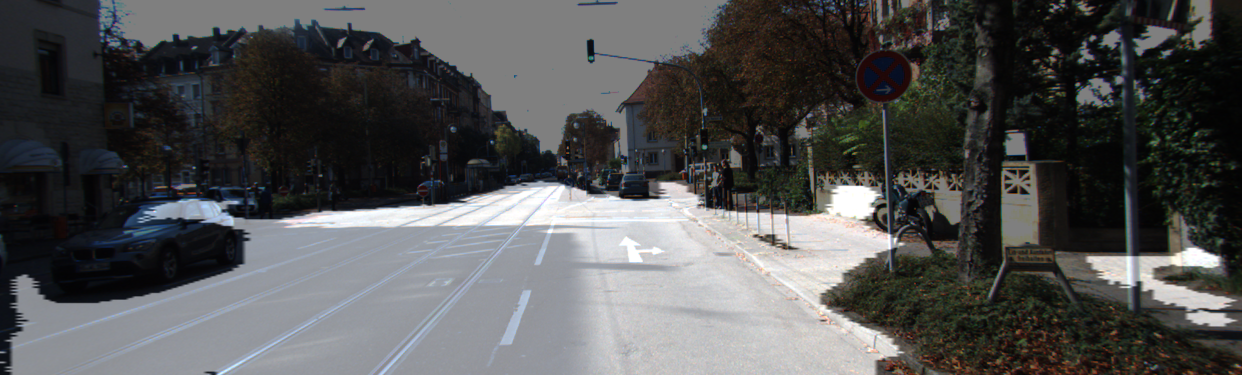

iou: 0.86

U-Net++(lr=1e-4, epoch=100)

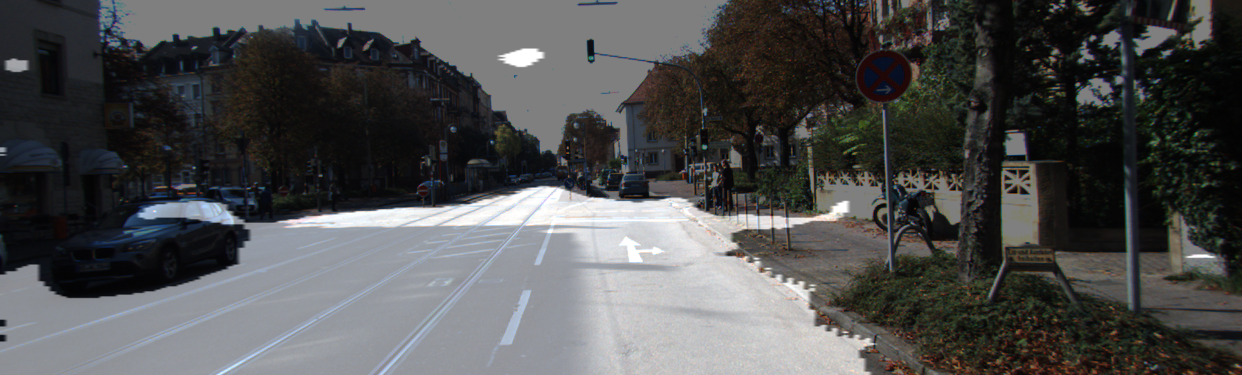

iou: 0.91  

얘네는 모델도 날려먹었습니다..ㅋㅋ

아쉽게도 이게 너무 훈련을 너무 많이 돌려서 lr과 epoch가 각각 기억이 나질 않는 점이 아쉽습니다..ㅠ  
하지만 맨 아래와 같이 20에포크처럼 너무 적게 epoch를 주지 않는 이상 50에포크 언저리만 나와도 성능이 꽤 되는 것을 확인할 수 있었습니다.

### 결론

정말 많은 일이 있었습니다..  
실험 과정을 대부분 날려먹어서 결과 이미지밖에 없지만 그간 경험이라도 글로 정리해보려고 합니다.  


1. U-Net의 구조에서 **BatchNormalization 부분을 제거하면 적은 학습률로도 빠른 결과가 도출**된다.
2. U-Net을 학습시 **일정 epoch(0.05 학습률 기준으로 100에포크) 아래에선 결과 자체가 나오지 않는다**... 학습률이 에포크에 비해 낮거나 학습률이 너무 높은 경우에도 결과가 아예 나오지 않았습니다.(도로로 인식한 영역이 없었다는 의미입니다.) 이유는 아마 학습의 부족이나 과적합 중 하나겠지요..?
3. **val_loss가 어느 한 지점에 수렴하더라도 결과가 나오지 않는다**...?(하지만 val_loss가 10에포크에서 100에포크까지 고정된 채로 학습을 하더라도 10에포크에선 결과가 안나오는데 100에포크에선 결과가 나왔습니다.. 왜 이러는 걸까요???? 정말 궁금합니다.)
4. **같은 학습률과 에포크를 지정하더라도 돌릴 때마다 결과가 굉장히 다르게 나온다**.(iou가 0.2가 됐다가 0.5가 됐다가 0.8이 됐다가...아예 0일때도 있었습니다...학습 정말 많이 돌렸는데 이유는 잘 모르겠네요. 이 이유때문에 결과를 다 날렸습니다ㅋㅋ 결과가 비슷하게 나올줄 알았는데 0이 나올줄은 몰랐습니다..ㅋㅋㅋㅋ)
5. U-Net++는 **적은 학습률로도 U-Net보다 결과가 뛰어나다.** 모델 파라미터가 U-Net보다 조금 더 많은 것을 위에서 확인할 수 있는데 어째서일까요? U-Net은 학습이 적으면 결과 자체가 안나오는데 U-Net++는 결과가 나오긴 합니다.
7. dice coef에 관한 내용입니다만 dice_coef작성시 참고한 깃헙 내용에 따르면 evaluation metric으로 IoU말고도 Dice를 따로 계산하는 함수가 존재하는데 이건 결과가 어떻게 나올지도 궁금하네요

## 추가 실험

[참고 링크3](https://m.blog.naver.com/j005580/221882044894)

사실 U-Net의 논문을 보면 인코더와 디코더의 이미지 크기가 padding이 없어 다르고 이로 인해 결과 크기가 다르게 나오는 것을 확인할 수 있습니다.  
다른 사람들의 U-Net 구현도 웬만하면 padding을 넣어 구현하는 경우가 많아 padding이 없는 예시를 찾기 힘들었지만 몇 가지 예시를 참고하여 다음 코드를 작성하였습니다.

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 인코더의 결과인 feature map들의 크기를 디코더의 이미지 크기에 맞게 crop하는 함수입니다.
def cropped_layer(input, crop_input):
    crop = crop_input
    x_shape = input.shape
    crop_shape = crop.shape
    offsets = [0, (crop_shape[1] - x_shape[1]), (crop_shape[2] - x_shape[2]), 0]
    size = [-1, x_shape[1], x_shape[2], -1]
    cropped = tf.slice(crop, offsets, size)
    x = Concatenate()([cropped, input])
    return x

def contracting_block(channels, inputs, dropout=False, maxpool=True):
    conv = Conv2D(channels, 3, padding='valid', kernel_initializer='he_normal')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    conv =  Conv2D(channels, 3, padding='valid', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    if dropout:
        conv = Dropout(0.5)(conv)
    if maxpool:
        pool = MaxPooling2D((2, 2))(conv)
        return conv, pool
    return conv

def Expanding_block(channels, inputs, conv):
    up = Conv2DTranspose(channels, 2, strides=(2, 2), padding="same")(inputs)
    merge = cropped_layer(up, conv) # 이 부분이 수정되었습니다.
    up = Conv2D(channels, 3, padding="valid", kernel_initializer='he_normal')(merge)
    up = BatchNormalization()(up)
    up = Activation("relu")(up)
    up = Conv2D(channels, 3, padding="valid", kernel_initializer='he_normal')(up)
    up = BatchNormalization()(up)
    up = Activation("relu")(up)
    return up

def unet_build(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    conv1, pool1 = contracting_block(64, inputs)

    conv2, pool2 = contracting_block(128, pool1)

    conv3, pool3 = contracting_block(256, pool2)

    conv4, pool4 = contracting_block(512, pool3, dropout=True)

    conv5 = contracting_block(1024, pool4, dropout=True, maxpool=False)

    up4 = Expanding_block(512, conv5, conv4)

    up3 = Expanding_block(256, up4, conv3)

    up2 = Expanding_block(128, up3, conv2)

    up1 = Expanding_block(64, up2, conv1)

    outputs = Conv2D(2, 3, activation='relu', padding='same')(up1)
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(outputs)
    
    # output의 결과가 label 이미지의 크기와 다르면 학습이 진행되지 않습니다.
    outputs = tf.image.resize(x, (inputs.shape[1], inputs.shape[2])) 

    model = Model(inputs, outputs)
    return model

이미지 crop을 하면 인코더 영역에서 결과물을 가져올 때 위치 정보를 얻는 이점이 테두리 부분의 손실로 인해 함께 사라질 것 같은데 이 crop을 convolution연산 대신 사용하는 이유가 뭘까 곰곰히 생각해봤습니다.  
제 생각에는 아마 mirro padding이라는 padding 방식 때문인 것 같습니다.

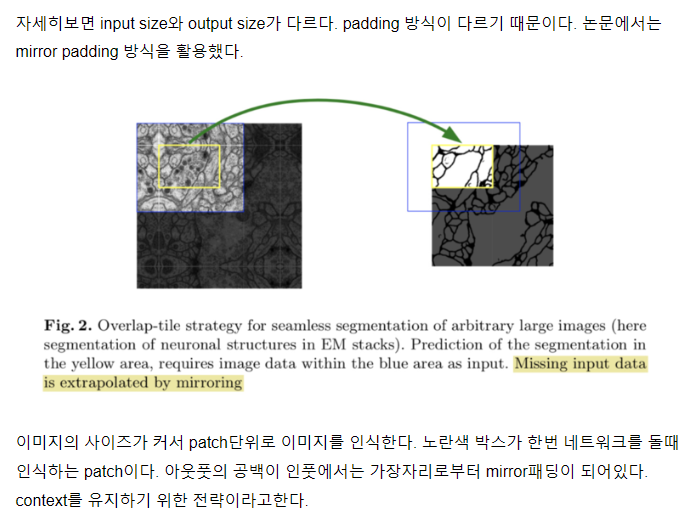

아마 위의 코드에서 작성했듯이 padding="same"처럼 단순히 일반적인 padding을 주는 것이 아니라 mirror padding을 따로 구현해야할 것 같습니다. mirror padding은 이미지 영역 밖을 마치 거울에 비춘 상처럼 대칭으로 채워넣어 convolution 연산을 수행합니다. 이로써 영역 밖의 이미지에 대한 정보도 이미지 내부에 포함시킬 수 있습니다.  

아마 이 mirror padding이 영역 밖의 정보를 영역 안에 추가해주기 때문에 crop을 해서 이미지 크기를 잘라내도 영역 밖의 정보가 이미 이미지 내부에 어느 정도 담겨있기 때문에 괜찮은 것이 아닌가 추측해봅니다..

이 모델도 한 번 테스트 해보고 싶었는데 시간이 부족해서 아쉽습니다...ㅠㅠ